# Domain Adaptation with Optimal Transport

This tutorial implements some optimal transport based unsupervised domain adaptation methods, introduced by [[Courty *et al*, 2016](https://arxiv.org/pdf/1507.00504.pdf)]. In doing so, it also illustrates how to use the IterativeLinearSolver of OTT-JAX to solve linear transport problem with an extra (non-entropic) regularization term.  

**The Domain Adaptation Setting**:
1. We are given labeled *source data*, denoted $(x_s, y_s)$, and unlabeled *target data* $(x_t)$, where $x_s$ and $x_t$ live in different domains $\Omega_s$ and $\Omega_t$ of the same metric space $\Omega$. 
1. We assume that the domain drift is due to an unknown, possibly nonlinear transformation of the target space $T\colon \Omega_t \to \Omega_s$, so that
$\mu_s = T_\sharp \mu_t,$ where  $\mu_s$ and $\mu_t$ denoting the source and the target marginal distribution over $x$, and that $T$ preserves the label information. 
1. As we have label information for the source data, we want to train a model (in the case of this tutorial a classifier), which we will then try to leverage to classify samples from the target domain

The idea is then to:


1. Estimate $\mu_s$ and $\mu_t$ with the corresponding empirical distributions.
1. Find a transport map $T$ from $\mu_t$ to $\mu_s$, defined as the solution of a potentially regularized optimal transport problem.
1. Transform target samples by inverting the transport map.
1. Use the classifier trained on the source data and apply it on the transformed target samples.  

In practice, we solve Kantorovitch formulation of the optimal transport problem, and add regularization, so that we get the following optimization problem:
$$\min_{\gamma \in \mathcal B} \langle \gamma, C \rangle_F +\epsilon H(\gamma) +\eta \Omega_c(\gamma),$$
where $\mathcal B = \{ \gamma \in (\mathbb R_+)^{n_t \times n_s}\mid \gamma 1_{n_s} = \mu_t,\, \gamma^\top 1_{n_t}=\mu_s\}$ is the set of probabilistic couplings between our empirical distributions, $H$ is the entropy,  and $\Omega_c$ is a class-based regularizing term, that we define later on.

## Imports and Utils:

In [1]:
from ott.solvers.generalized_contidional_gradient import ConditionalGradient

In [2]:
from typing import NamedTuple, Tuple

import jax
import jax.numpy as jnp
import numpy as np
from jax import random
from jaxopt import BacktrackingLineSearch
from sklearn import cluster, datasets, mixture
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.colors import ListedColormap

from ott.geometry import costs, pointcloud
from ott.geometry.geometry import Geometry
from ott.problems.linear import linear_problem
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear import sinkhorn

In [3]:
def get_moon_data(num_s=300, num_t=300, angle=30):
    """
    Generates the the source two moons dataset, then rotate it by
    angle to generate the target
    """
    x_s, y_s = datasets.make_moons(n_samples=num_s, noise=0.05, random_state=42)
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    x_t = np.dot(x_s, R)
    return jnp.array(x_s), jnp.array(y_s), jnp.array(x_t[:num_t])


def get_gaussian_data(key, n_source=75, n_targets=75):
    """
    Generates the source data of two 2D gaussian,
    applies a linear transformation to create the target data
    """
    key, *subkey = random.split(key, 5)
    x_0 = jax.random.normal(subkey[0], (n_source, 2))
    x_1 = 1.3 * jnp.ones((n_source, 2)) + jax.random.normal(
        subkey[1], (n_targets, 2)
    )
    x_s = jnp.concatenate([x_0, x_1], axis=0)
    y_s = jnp.concatenate(
        [jnp.zeros(shape=(n_source,)), jnp.ones(shape=(n_targets,))], axis=0
    )
    x_t0 = 3 * jnp.ones((n_source, 2)) + jax.random.normal(
        subkey[2], (n_targets, 2)
    )
    x_t1 = 7.6 * jnp.ones((n_source, 2)) + jax.random.normal(
        subkey[3], (n_targets, 2)
    )
    x_t = jnp.concatenate([x_t0, x_t1], axis=0)
    return jnp.array(x_s), jnp.array(y_s).astype(int), jnp.array(x_t)


def train_plot(x_s, y_s, x_t, G=None):
    """
    Train a Gaussian process classifier on the source data x_s, y_s.
    If G=None, the classifier is then applied on the target data x_t
    If G is not None, the classifier is also tested on the (scale normalized) transformation of x_t by G
    The accurcay and classification zones are draw.
    """
    if G == None:
        n_samples = y_s.shape[0]
        num_classes = np.bincount(y_s).shape[0]
        plt.figure(1, figsize=(10, 10))
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(
            ["#FF0000", "#0000FF", "#00FF00"][:num_classes]
        )
        x_min = min(np.min(x_s[:, 0]), np.min(x_t[:, 0])) * 1.25
        x_max = max(np.max(x_s[:, 0]), np.max(x_t[:, 0])) * 1.25
        y_min = min(np.min(x_s[:, 1]), np.min(x_t[:, 1])) * 1.25
        y_max = max(np.max(x_s[:, 1]), np.max(x_t[:, 1])) * 1.25
        x_min, y_min = min(x_min, y_min), min(x_min, y_min)
        x_max, y_max = max(x_max, y_max), max(x_max, y_max)

        titles = ["Source Data", "Target Data"]
        for i, x in enumerate([x_s, x_t]):
            pl.subplot(2, 2, i + 1)
            plt.scatter(
                x[:, 0],
                x[:, 1],
                c=y_s,
                cmap=cm_bright,
                marker="p",
                edgecolor="k",
                label="_m",
            )
            plt.xlim([x_min, x_max])
            plt.ylim([y_min, y_max])
            pl.title(titles[i])

        # We train the classifier on source data
        clf = GaussianProcessClassifier(1.0 * RBF(1.0))
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(x_s, y_s)

        for i, x in enumerate([x_s, x_t]):
            ax = pl.subplot(2, 2, i + 3)
            plt.xlim([x_min, x_max])
            plt.ylim([y_min, y_max])
            pl.title("Classifier Performance on: " + titles[i])
            score = clf.score(x, y_s)
            DecisionBoundaryDisplay.from_estimator(
                clf,
                np.concatenate((x_s, x_t)),
                cmap=cm,
                alpha=0.8,
                ax=ax,
                eps=2.0,
            )
            plt.scatter(
                x[:, 0],
                x[:, 1],
                c=y_s,
                cmap=cm_bright,
                edgecolors="k",
                label="_m",
            )
            ax.set_title("Classifier on: " + titles[i])
            ax.text(
                0.9 * x_max,
                0.9 * y_max,
                "score: " + ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )

        plt.tight_layout()
        plt.show()

    else:
        n_samples = y_s.shape[0]
        x_t_hat = n_samples * jnp.dot(G, x_s)
        num_classes = np.bincount(y_s).shape[0]
        plt.figure(1, figsize=(15, 10))
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(
            ["#FF0000", "#0000FF", "#00FF00"][:num_classes]
        )
        x_min = min(np.min(x_s[:, 0]), np.min(x_t[:, 0])) * 1.25
        x_max = max(np.max(x_s[:, 0]), np.max(x_t[:, 0])) * 1.25
        y_min = min(np.min(x_s[:, 1]), np.min(x_t[:, 1])) * 1.25
        y_max = max(np.max(x_s[:, 1]), np.max(x_t[:, 1])) * 1.25
        x_min, y_min = min(x_min, y_min), min(x_min, y_min)
        x_max, y_max = max(x_max, y_max), max(x_max, y_max)

        titles = ["Source Data", "Target Data", "Transported Target Data"]
        for i, x in enumerate([x_s, x_t, x_t_hat]):
            pl.subplot(2, 3, i + 1)
            plt.scatter(
                x[:, 0],
                x[:, 1],
                c=y_s,
                cmap=cm_bright,
                marker="p",
                edgecolor="k",
                label="_m",
            )
            plt.xlim([x_min, x_max])
            plt.ylim([y_min, y_max])
            pl.title(titles[i])

        # We train the classifier on source data
        clf = GaussianProcessClassifier(1.0 * RBF(1.0))
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(x_s, y_s)

        for i, x in enumerate([x_s, x_t, x_t_hat]):
            ax = pl.subplot(2, 3, i + 4)
            plt.xlim([x_min, x_max])
            plt.ylim([y_min, y_max])
            pl.title("Classifier Performance on: " + titles[i])
            score = clf.score(x, y_s)
            DecisionBoundaryDisplay.from_estimator(
                clf,
                np.concatenate((x_s, x_t, x_t_hat)),
                cmap=cm,
                alpha=0.8,
                ax=ax,
                eps=2.0,
            )
            plt.scatter(
                x[:, 0],
                x[:, 1],
                c=y_s,
                cmap=cm_bright,
                edgecolors="k",
                label="_m",
            )
            ax.set_title("Classifier on: " + titles[i])
            ax.text(
                0.9 * x_max,
                0.9 * y_max,
                "score: " + ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )

        plt.tight_layout()
        plt.show()

## Naive Approach 

We consider two toy source datasets: (1) the two semi-moon dataset (2) a 2D Gaussian mixture of 2 components. A transformation is applied to each to create the two target dataset. To illustrate the need for domain adapatation, a Gaussian process classifier is trained on the source data and is then used to classify the target data.

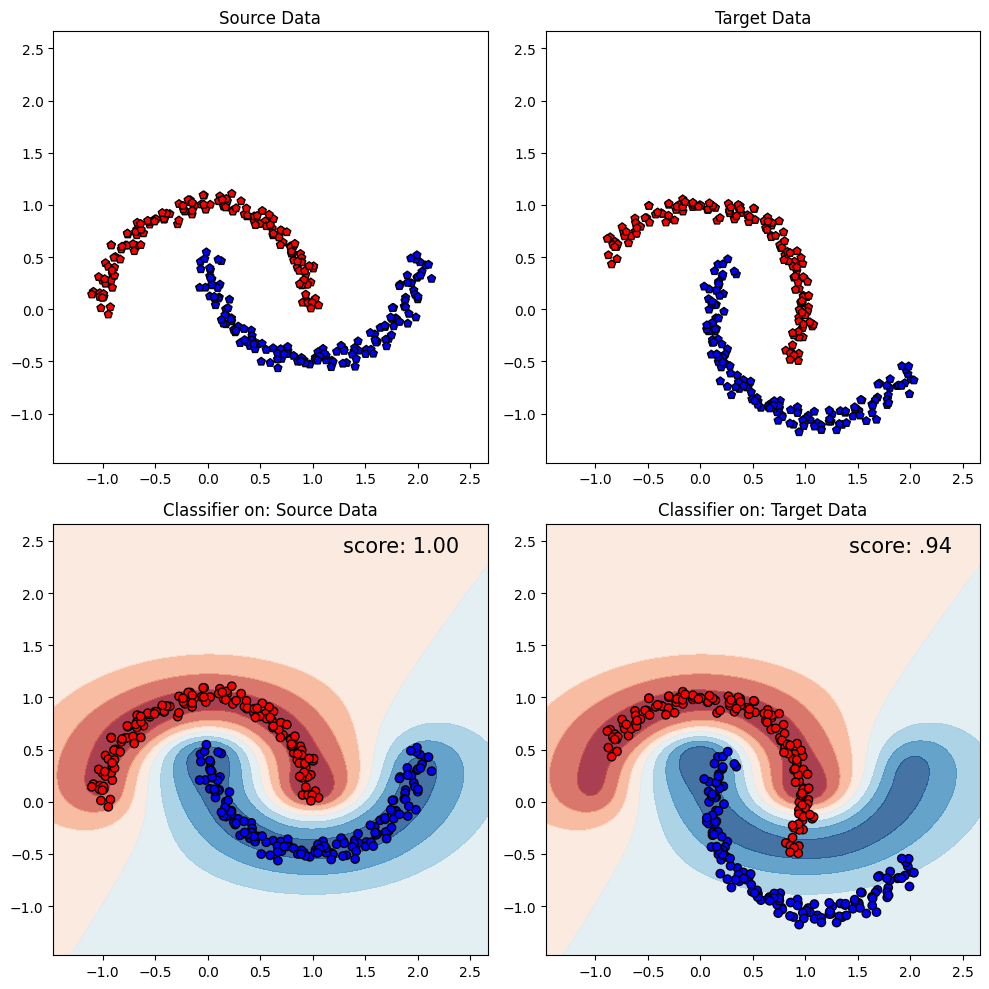

In [4]:
# Moon Data
mx_s, my_s, mx_t = get_moon_data()
# Gaussian Data
gx_s, gy_s, gx_t = get_gaussian_data(random.PRNGKey(42))
train_plot(mx_s, my_s, mx_t)

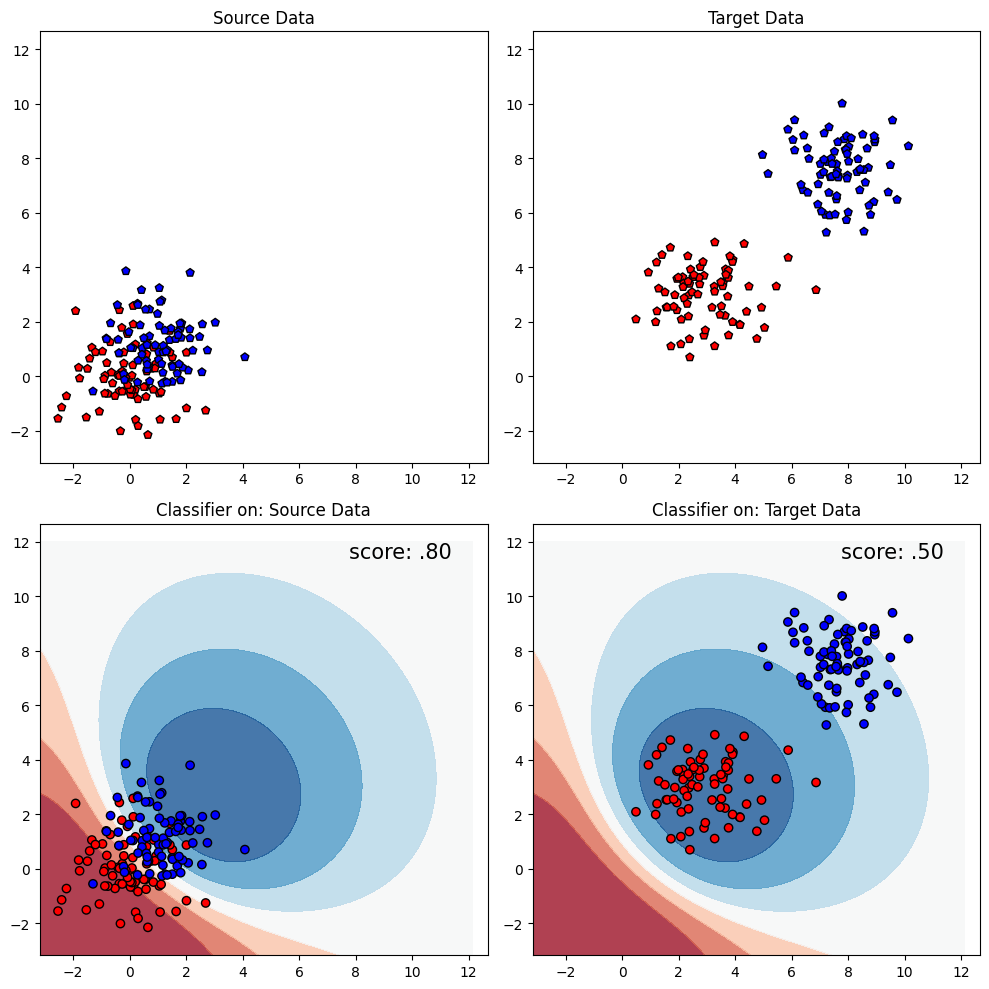

In [5]:
train_plot(gx_s, gy_s, gx_t)

## Domain Adaptation with Regularization

### Generalized Conditional Gradient 

Finding the transport map $T$ is done through solving an entropic regularized linear transport problem that is further regularized by $\Omega_c$. We use the Generalized Conditional Gradient GCG [[Courty *et al*, 2016](https://arxiv.org/pdf/1507.00504.pdf)], which aims to minimize problems of the form 
$$g(\gamma) = \langle \gamma, C \rangle_F +\epsilon H(\gamma) +\eta \Omega_c(\gamma)$$ 

by first setting $f(\gamma)= \langle \gamma, C \rangle_F  +\eta \Omega_c(\gamma)$. Then iteratively 

1. Compute $\mathbf{G}_k = \nabla f(\gamma_k)$
1. find $\gamma^*_k  = \text{argmin}_{\gamma \in \mathcal{B}} \langle\gamma,\mathbf{G}_k \rangle_F +\varepsilon H(\gamma)$
1. Using a line search method, find $\gamma_{k+1}$ by minimizing $g$ on the line segment between $\gamma_k$ and $\gamma^*_k$

Looking at (2), ConditionalGradient can be seen as a method iteratively solving a series of linear OT problems. OTT-JAX provides IterativeLinearSolver which allows the user to quickly implement methods that relies on iteratively solving linear problems. To use IterativeLinearSolver, the user needs to implement: 
1. ProblemState: a NamedTuple gathering problem specific state variables. This substate forms a part of the solver state. 
1. next_linear_pb: a function taking the current solver state (including ProblemState) and a random key to output a new linear problem.
1. new_pstate_cost: a function that takes a solver state, a linear problem, solution to the linear problem, and a random key to output a new ProblemState and a cost associate with the current iteration.


We now now implement a ProblemState and a general function to construct the ingredients  for GCG.

### Laplace Regularization

We first consider the Laplacian regularization. Given two positive and symmetric similarity matrices $S_s$ and $S_t$ for source data and target data, it is defined as
$$\Omega_c(\gamma) = \mathrm{Tr} (X_s^\top \gamma ^\top L_t \gamma X_s) + \mathrm{Tr} (X_t^\top \gamma  L_s \gamma^\top X_t)$$
where $L_s = \mathrm{diag}(S_s1)-S_s$ (resp. $L_t$) is the Laplacian of the similarity matrix $S_s$ (resp. $S_t$). We compute $S_s$ and $S_t$ with scikit-learn function kneighbors_graph.

In [6]:
def lap_reg(source_data, target_data, sim_param=5, alpha=0.5):
    """
    ground_cost: the transport cost matrix of the underlying transport problem
    source_data: the sample data of the source
    target_data: the sample data of the target
    sim_param:  parameter of the graph computations in the laplaciancs
    alpha: relative weight on the two terms in laplacian regularization

    return: the laplace loss function corresponding to the inputs
    """
    # Initializing the Laplacian auxilary state
    x_s, x_t = source_data, target_data

    def laplacian(x):
        return jnp.diag(jnp.sum(x, axis=0)) - jnp.array(x)

    sS = kneighbors_graph(x_s, n_neighbors=int(sim_param)).toarray()
    sT = kneighbors_graph(x_t, n_neighbors=int(sim_param)).toarray()
    sS = jnp.array((sS + sS.T) / 2)
    lS = laplacian(sS)
    sT = jnp.array((sT + sT.T) / 2)
    lT = laplacian(sT)

    def laplace_loss(cost_mat):
        a = alpha * jnp.trace(x_t.T @ cost_mat @ lS @ cost_mat.T @ x_t)
        b = (1 - alpha) * jnp.trace(x_s.T @ cost_mat.T @ lT @ cost_mat @ x_s)
        return a + b

    return laplace_loss

**Gaussian Data**

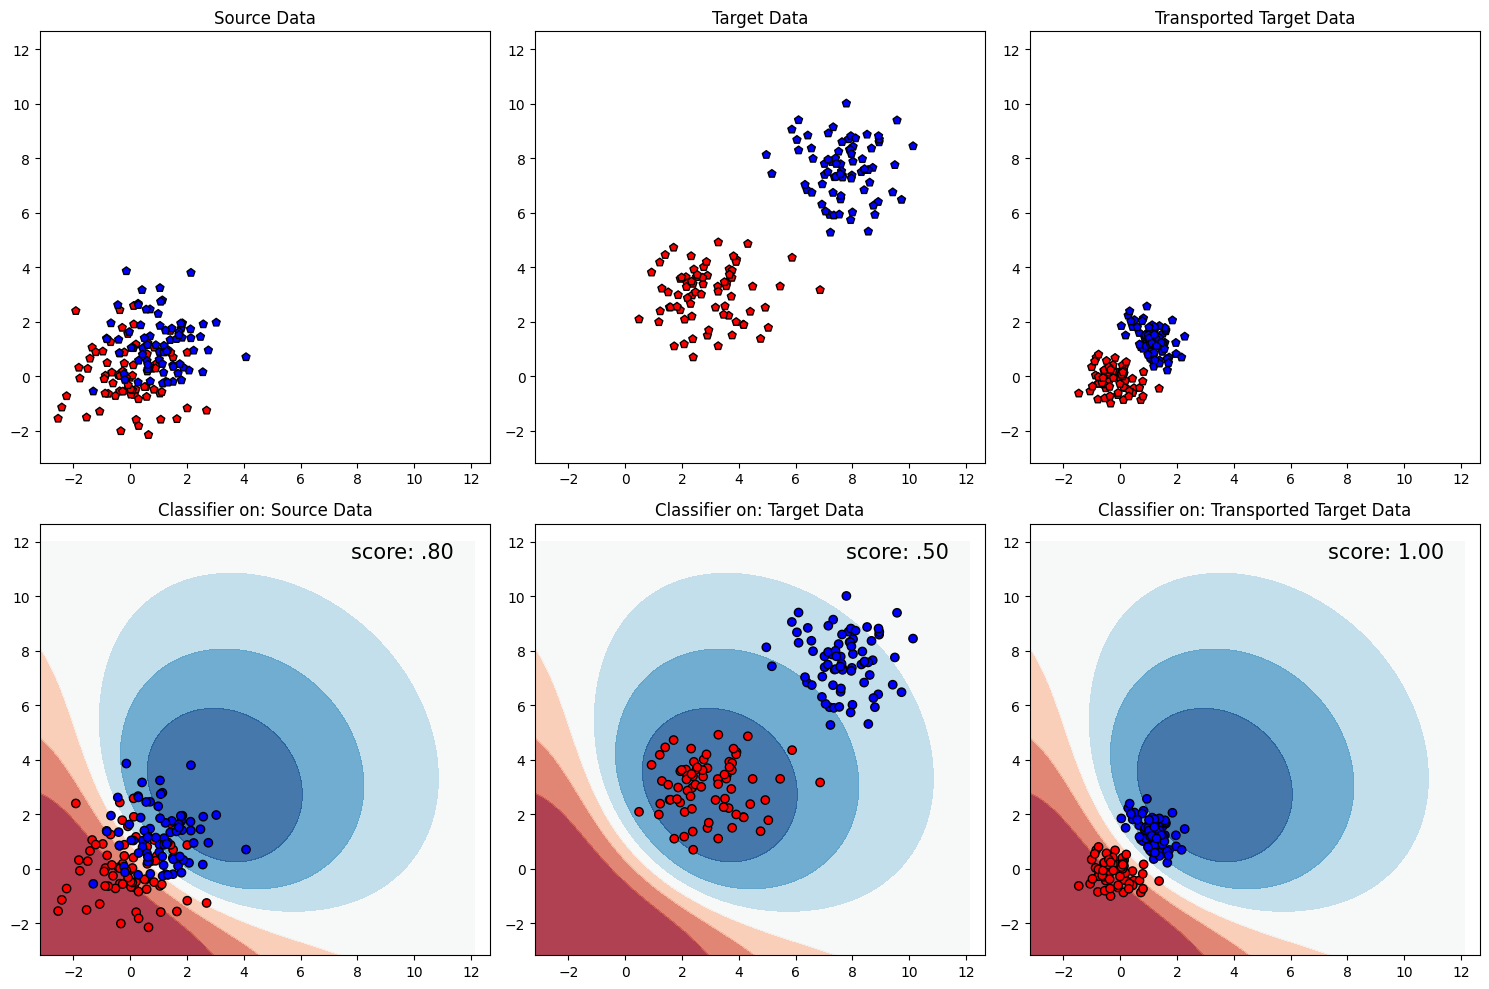

In [7]:
reg = 0.5
epsilon = 10e-1

# the Gaussian Mixture
geom = pointcloud.PointCloud(gx_s, gx_t)
cost_mat = geom.cost_matrix
init_linear_pb = linear_problem.LinearProblem(Geometry(cost_mat, epsilon))
lap_loss = lap_reg(gx_s, gx_t)

solver = ConditionalGradient(
    epsilon=epsilon,
    threshold=1e-3,
    store_inner_errors=True,
)

last_state = solver(
    cost_mat, lap_loss, epsilon, reg, init_linear_pb=init_linear_pb
)

last_solution = last_state.sol_matrix
train_plot(gx_s, gy_s, gx_t, G=last_solution.T)

**Semi-Moon Data**

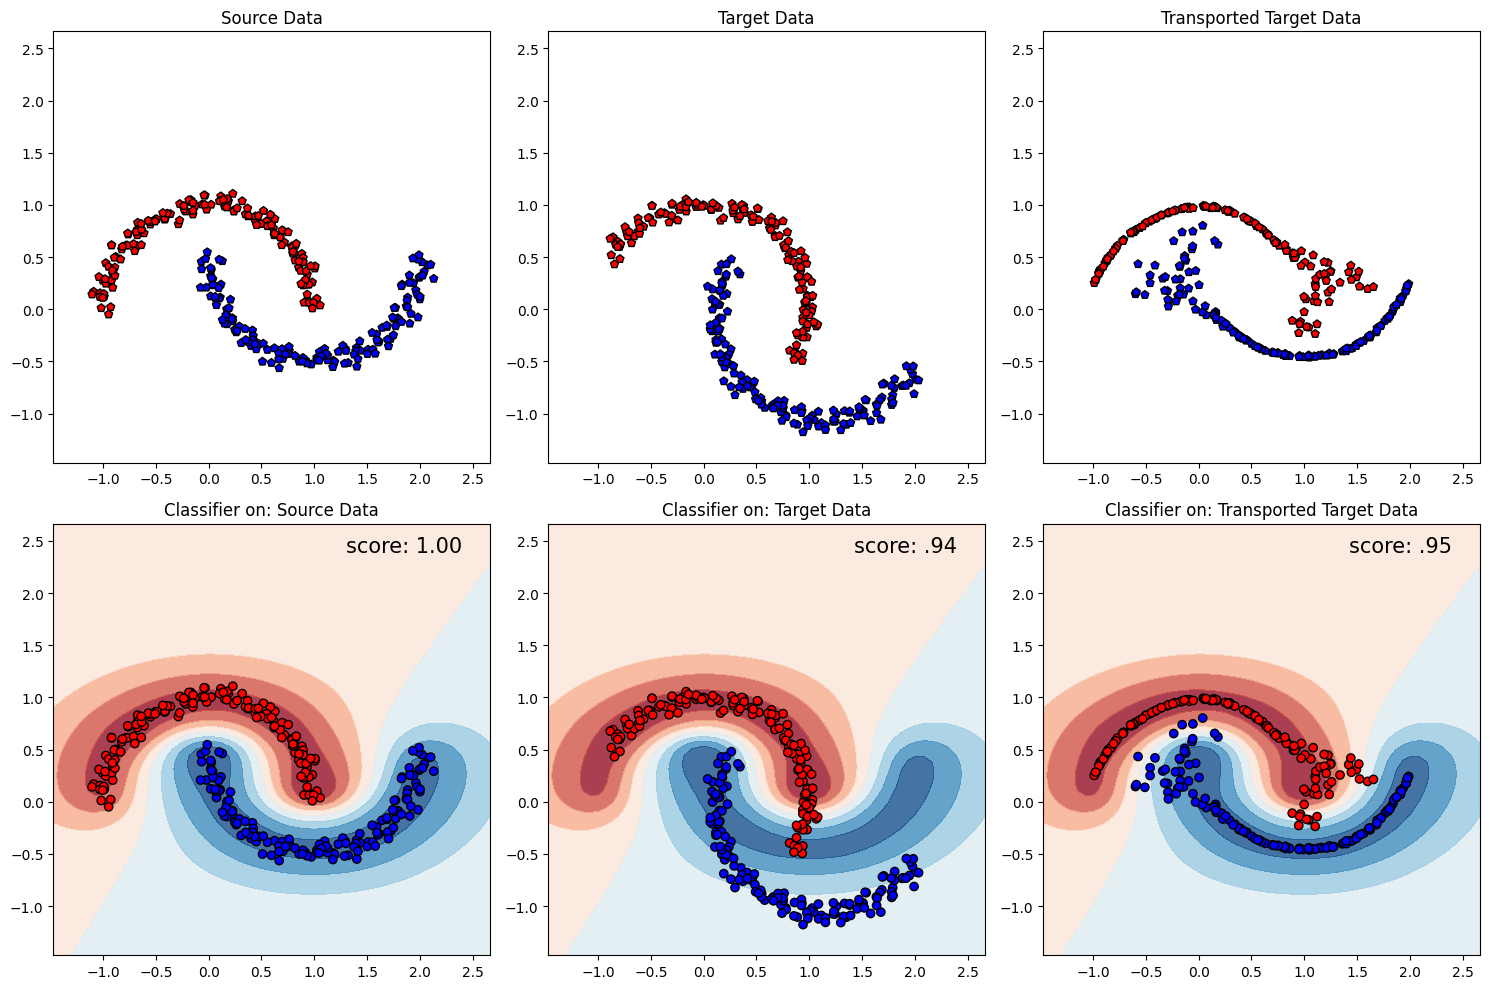

In [8]:
reg = 0.5
epsilon = 10e-1

# the Gaussian Mixture
geom = pointcloud.PointCloud(mx_s, mx_t)
cost_mat = geom.cost_matrix
init_linear_pb = linear_problem.LinearProblem(Geometry(cost_mat, epsilon))
lap_loss = lap_reg(mx_s, mx_t)

solver = ConditionalGradient(
    epsilon=epsilon,
    threshold=1e-3,
    store_inner_errors=True,
)

last_state = solver(
    cost_mat, lap_loss, epsilon, reg, init_linear_pb=init_linear_pb
)

last_solution = last_state.sol_matrix

train_plot(mx_s, my_s, mx_t, G=last_solution.T)

### Group Sparsity Regularization

We now consider group sparsity regularization, defined as:
$$ \Omega_c (\gamma) = \sum_{i=1}^{n_{samples}} \sum_{cl} \|\gamma(i,\mathcal I_{cl})\|_2,$$
where $cl$ runs through all classes, and $I_{cl}$ contains the indices of columns in $\gamma$ related to source domain samples of class $cl$.

In [9]:
def sparse_reg(source_labels, class_num=2):
    """
    source_labels: the labels of the datapoints in the source domain
    class_num: the number of classes in the source domain
    """
    # Initializing the Laplacian auxilary state
    index_matrix = jnp.vstack([source_labels == i for i in range(class_num)])
    index_matrix = jnp.expand_dims(index_matrix, 2)

    def _sparse_reg(cost_mat):
        cost_mat = jnp.expand_dims(cost_mat, axis=0)
        res = jnp.sum(jnp.linalg.norm((cost_mat * index_matrix), axis=1))
        iszero = jnp.isclose(res, 0)
        res = jnp.where(iszero, 1, res)
        res = res**0.5
        res = jnp.where(iszero, 0, res)
        return jnp.sum(res)

    return _sparse_reg

Since all the operations for sparse regularization are JITable, we can write a solver function and JIT it to improve the performance! This wasn't the case for Laplacian regularization because of the sklearn method but can be easily overcome by writing the function slightly differently.

In [10]:
@jax.jit
def sparse_solver(x_s, y_s, x_t, reg=0.5, epsilon=10e-1):
    geom = pointcloud.PointCloud(x_s, x_t)
    cost_mat = geom.cost_matrix
    init_linear_pb = linear_problem.LinearProblem(Geometry(cost_mat, epsilon))
    sparse_loss = sparse_reg(y_s)
    solver = ConditionalGradient(
        epsilon=epsilon,
        threshold=1e-3,
        store_inner_errors=True,
    )

    last_state = solver(
        cost_mat, sparse_loss, epsilon, reg, init_linear_pb=init_linear_pb
    )
    return last_state.sol_matrix

**Gaussian Data**

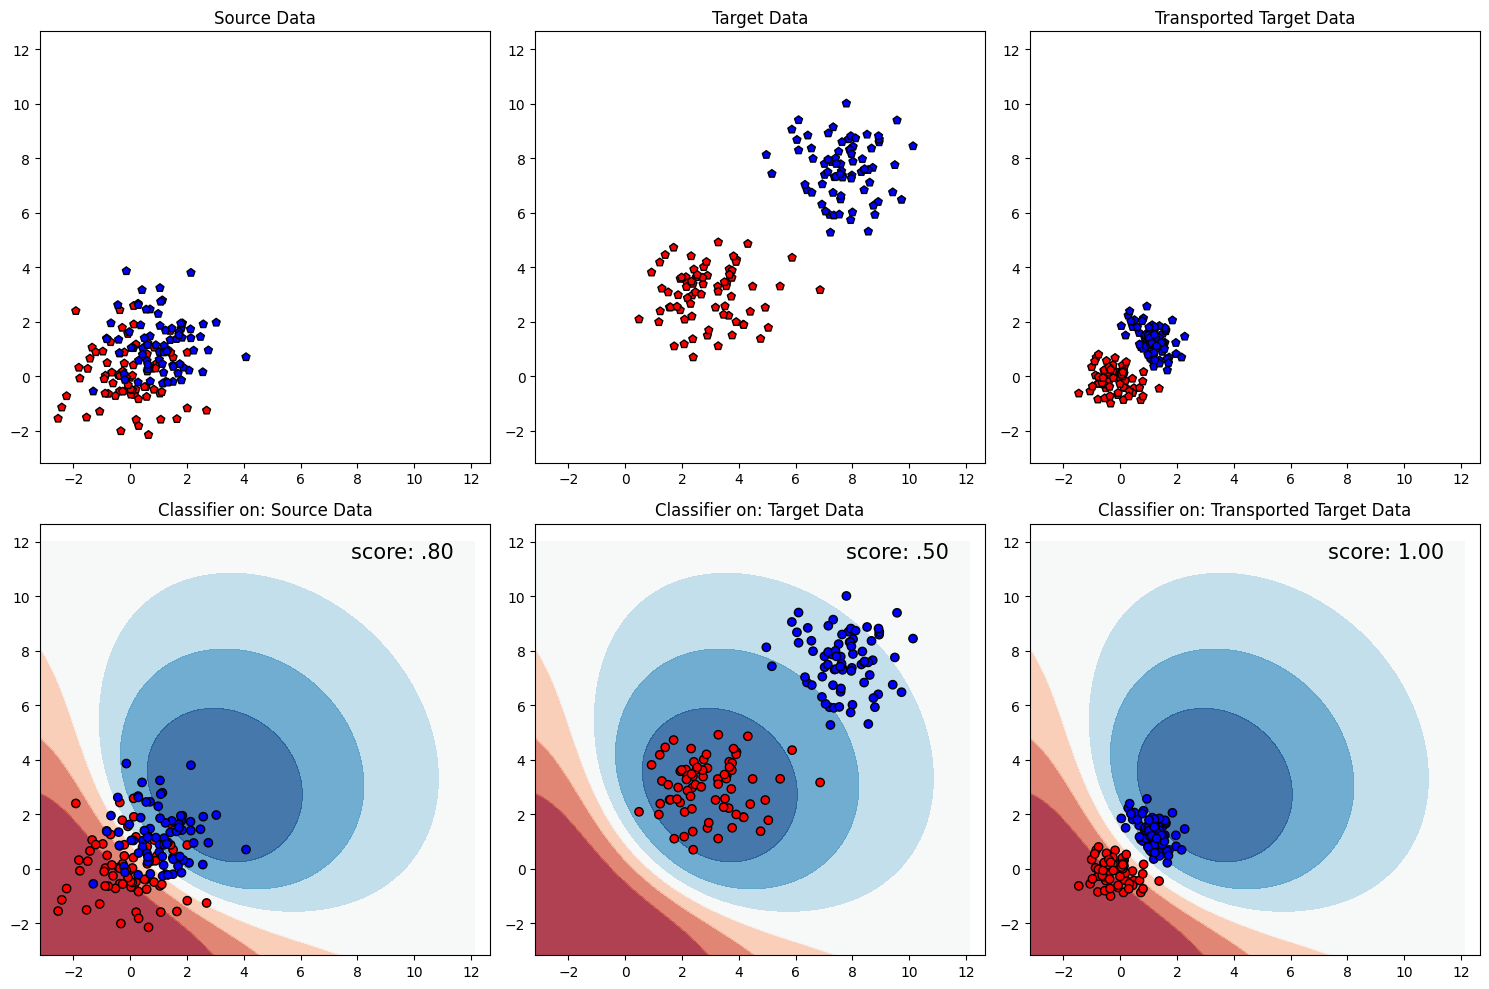

In [11]:
transform_mat = sparse_solver(gx_s, gy_s, gx_t)
train_plot(gx_s, gy_s, gx_t, G=transform_mat.T)

**Semi-Moon Loss**

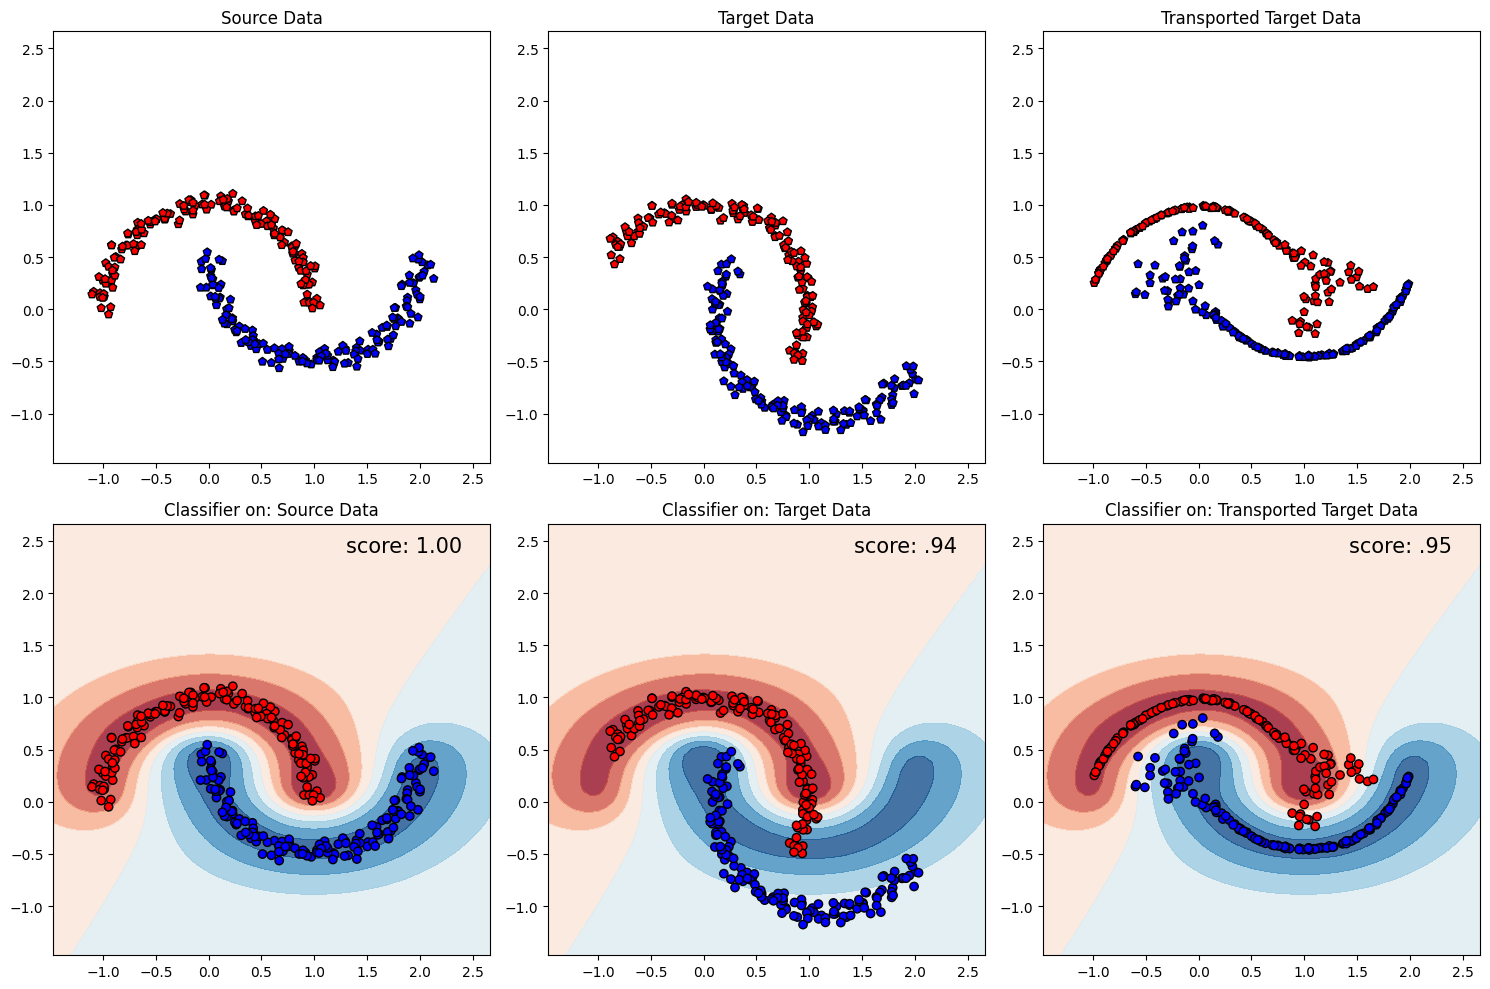

In [12]:
transform_mat = sparse_solver(mx_s, my_s, mx_t)
train_plot(mx_s, my_s, mx_t, G=transform_mat.T)